### **Simulating Adaptive Sensor Networks for Temperature Reporting**

---

#### **Overview**

This Jupyter Notebook explores the performance and efficiency of an **adaptive sensor network** designed for temperature reporting. The experiment incorporates both **adaptive reporting** and **fixed-interval reporting** techniques, while introducing a **network simulator** to evaluate collision rates as sensor counts increase.

The simulation is driven by real-world temperature grids derived from **ERA5 weather data**, focused on a 14x14 grid of latitude and longitude coordinates.

---

#### **Objectives**

1. **Sensor Placement**: 
   - Simulate a network of sensors randomly placed on a geographic temperature grid.
   - Dynamically extract temperature readings for each sensor.

2. **Adaptive Reporting**: 
   - Implement adaptive temperature reporting logic:
     - **Fine granularity** (1°C) for low temperatures (< 20°C).
     - **Coarser granularity** (2°C) for moderate temperatures (20°C–30°C).
     - **Logarithmic scale** for extreme temperatures (> 30°C).

3. **Network Simulation**: 
   - Simulate data transmissions across a shared communication channel using **time slots**.
   - Measure **collision rates** under:
     - Fixed-interval reporting (traditional sensors reporting every time slot).
     - Adaptive reporting (reduced transmissions based on temperature logic).

4. **Collision Analysis**:
   - Perform an experiment to test **collision rates** for increasing sensor counts (1 to 100 sensors).
   - Compare fixed reporting vs. adaptive reporting to observe efficiency improvements.

---

#### **Experiments**

1. **Collision Rate Simulation**:
   - Randomly place sensors on the temperature grid.
   - Simulate data transmissions in a shared channel using a defined number of time slots per hour.
   - Evaluate collision rates for:
     - **Fixed-Interval Reporting**: Sensors report temperature at every time slot.
     - **Adaptive Reporting**: Sensors report based on temperature thresholds, reducing transmissions.

2. **Experiment: Scaling the Network**:
   - Vary the number of sensors from **1 to 100**.
   - Measure collision rates for both fixed and adaptive reporting.
   - Visualize the results as a **line graph** showing collision rate vs. number of sensors.

---

#### **Key Features**

- **Real Data**: Temperature grids from ERA5 weather data.
- **Adaptive Reporting Logic**: Balances precision and efficiency based on temperature thresholds.
- **Network Simulation**: Evaluates communication efficiency in terms of collision rates.
- **Visualization**:
   - Actual vs. reported temperatures.
   - Collision rate comparisons between fixed and adaptive reporting.
   - Summary tables for sensor efficiency metrics.

---

#### **Applications**

This experiment demonstrates the benefits of **adaptive sensing** in reducing network collisions and improving efficiency. It can be extended to various scenarios, such as:
- **Wildfire Monitoring**: Deploying adaptive sensors to monitor extreme temperature variations.
- **IoT Networks**: Optimizing energy and bandwidth usage for environmental monitoring.
- **Scalable Sensor Systems**: Understanding how networks behave as sensor counts increase.

---


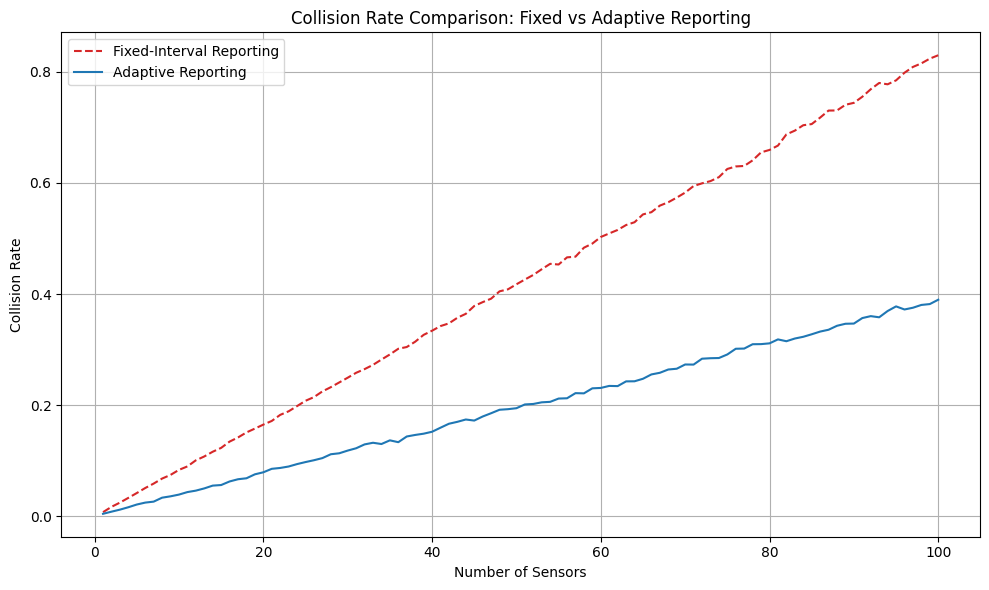

   Sensor Count  Fixed Collision Rate  Adaptive Collision Rate
0             1              0.007639                 0.004687
1             2              0.017188                 0.008507
2             3              0.024826                 0.012153
3             4              0.033333                 0.016493
4             5              0.042014                 0.021354


In [8]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from math import radians, cos, sin, sqrt, atan2

# Load the NetCDF data file
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Define the central hub location (average grid center)
central_lat, central_lon = ds["latitude"].mean().values, ds["longitude"].mean().values

# Haversine formula to compute distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2.0) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2.0) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Adaptive reporting logic
def adaptive_reporting(temp):
    """Adaptive temperature reporting logic:
       - Fine granularity (1°C) below 20°C.
       - Coarser granularity (2°C) between 20°C and 30°C.
       - Logarithmic scale at extreme high temperatures (>30°C).
    """
    temp = temp.item() if isinstance(temp, np.ndarray) else temp  # Convert array to scalar if needed
    if temp < 20:
        return round(temp)  # Report to nearest 1°C
    elif 20 <= temp <= 30:
        return round(temp / 2) * 2  # Report to nearest 2°C
    elif temp > 30:
        return round(temp / 5) * 5  # Report to nearest 5°C
    return temp  # Fallback

# Simulate and analyze collisions in the network
def simulate_network(n_sensors, slots_per_hour=60):
    np.random.seed(42)  # Ensure repeatability
    
    # Randomly generate sensor locations
    latitudes = ds["latitude"].values
    longitudes = ds["longitude"].values
    sensor_locations = [(np.random.choice(latitudes), np.random.choice(longitudes)) for _ in range(n_sensors)]
    
    collisions_fixed = 0
    collisions_adaptive = 0
    fixed_transmissions = [[] for _ in range(n_sensors)]
    adaptive_transmissions = [[] for _ in range(n_sensors)]
    
    # Simulate reporting for each sensor
    for idx, (sensor_lat, sensor_lon) in enumerate(sensor_locations):
        sensor_data = ds["t2m_celsius"].sel(latitude=sensor_lat, longitude=sensor_lon)
        temperature_readings = sensor_data.values

        for t, temp in enumerate(temperature_readings):
            # Fixed reporting: sensor reports temperature every slot
            slot_fixed = np.random.randint(0, slots_per_hour)
            if slot_fixed in fixed_transmissions[idx]:
                collisions_fixed += 1
            else:
                fixed_transmissions[idx].append(slot_fixed)

            # Adaptive reporting
            reported_temp = adaptive_reporting(temp)
            if reported_temp % 2 == 0:  # Simplistic collision reduction logic
                slot_adaptive = np.random.randint(0, slots_per_hour)
                if slot_adaptive in adaptive_transmissions[idx]:
                    collisions_adaptive += 1
                else:
                    adaptive_transmissions[idx].append(slot_adaptive)
    
    # Calculate collisions per slot used
    fixed_collision_rate = collisions_fixed / (slots_per_hour * len(temperature_readings))
    adaptive_collision_rate = collisions_adaptive / (slots_per_hour * len(temperature_readings))

    
    return fixed_collision_rate, adaptive_collision_rate

# Experiment: Test collision rates for 1 to 100 sensors
def experiment_collision_rates(max_sensors=100):
    sensor_counts = list(range(1, max_sensors + 1))
    fixed_rates = []
    adaptive_rates = []
    
    for n in sensor_counts:
        #print(f"Simulating network with {n} sensors...")
        fixed_rate, adaptive_rate = simulate_network(n_sensors=n)
        fixed_rates.append(fixed_rate)
        adaptive_rates.append(adaptive_rate)
    
    # Plot collision rates
    plt.figure(figsize=(10, 6))
    plt.plot(sensor_counts, fixed_rates, label="Fixed-Interval Reporting", color="tab:red", linestyle="--")
    plt.plot(sensor_counts, adaptive_rates, label="Adaptive Reporting", color="tab:blue", linestyle="-")
    plt.title("Collision Rate Comparison: Fixed vs Adaptive Reporting")
    plt.xlabel("Number of Sensors")
    plt.ylabel("Collision Rate")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Return results as a DataFrame
    return pd.DataFrame({
        "Sensor Count": sensor_counts,
        "Fixed Collision Rate": fixed_rates,
        "Adaptive Collision Rate": adaptive_rates
    })

# Run the collision rate experiment
collision_results = experiment_collision_rates(max_sensors=100)

# Display results
print(collision_results.head())
